In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import os
import glob #retrieve file directories

In [2]:
# Set font properties using rcParams
plt.rcParams['font.family'] = 'Arial'

#### Import raw sensor data

In [3]:
#import raw data. change the path to the location of the data on your computer
data_dir=r'W:\VUB\TMS network\data\UNESCO_IHP__WINS\raw_field_data'

#from the data directory import data from all loggers. Files with data are labelled beginning with data--. 
# The files should not be renamed otherwise the code will need
data_files=glob.glob(os.path.join(data_dir,'data*')) #load all files starting with rf in the folder

#read coordinates file. Change the path to the location of the file on your computer
coords_df=pd.read_csv(r"W:\VUB\TMS network\data\UNESCO_IHP__WINS\raw_field_data\locations_epsg_4326.csv")

In [4]:
#extract the logger names from the file names
loggers=[]
for data_file in data_files:
    names=os.path.basename(data_file).split('_')[1]
    loggers.append(names)

In [5]:
coords_df

,longitude,latitude,logger_id,country,date installed in the field
0,34.838807,0.121576,94252964,Kenya,30th May 2023
1,34.748363,0.121715,94252965,Kenya,30th May 2023
2,34.748725,0.121486,94252962,Kenya,30th May 2023
3,34.838826,0.118434,94252961,Kenya,30th May 2023
4,-79.960000,22.424000,95135586,Cuba,4th July 2023
5,-7.888000,32.220000,94202374,Morocco,28th December 2023
6,37.130000,-3.367000,95135588,Tanzania,3rd July 2023
7,37.234000,-3.199000,95135589,Tanzania,3rd July 2023
8,39.650000,8.610000,95135590,Ethiopia,8th August 2023
9,33.509923,-13.172981,97378401,Malawi,Sep-23


In [14]:
#provide column names as they are arranged in the data files
col_names=['date','timezone','Temp: -6cm','Temp: 0 cm','Temp: +12 cm','raw sensor reading']

In [7]:
#Extract data from the files and store in a readable format
#Assign time properly and resample as needed
micro_climate_data=[]
for st in data_files:
    logger_data=pd.read_csv(st, sep=';', header=None)
    logger_data=logger_data.iloc[:,1:7]
    logger_data.columns=col_names

    #convert date to datetime. Check for different date formats
    logger_data['datetime'] = pd.to_datetime(logger_data['date'], format='%Y.%m.%d %H:%M', errors='coerce') #for date format YYYY-MM-DD-H:M
    mask = logger_data.datetime.isnull()
    logger_data.loc[mask, 'datetime'] = pd.to_datetime(logger_data[mask]['date'], format='%d.%m.%Y',errors='coerce') #for date format DDMMYYYY
    mask2=logger_data.datetime.isnull()
    logger_data.loc[mask2, 'datetime'] = pd.to_datetime(logger_data[mask2]['date'], format='%d.%m.%Y %H:%M:%S',errors='coerce') #for date format DDMMYYYY-H:M
    
    logger_data_timeindex=logger_data.set_index('datetime').drop('date', axis=1)
    logger_data_timeindex.replace(',', '.', regex=True, inplace=True) #replace , with . in Temp values
    logger_data_timeindex=logger_data_timeindex.astype(float)
    logger_data_timeindex=logger_data_timeindex.drop('timezone', axis=1)
    #resample to desired time interval
    data=logger_data_timeindex.resample('6h').mean()
    data['logger_id']=os.path.basename(st).split('_')[1]


    micro_climate_data.append(data)

    #concatenate all dataframes
    micro_climate_df=pd.concat(micro_climate_data)

#### **Calibration of soil Mositure**.
This section provides a generic calibration curve for soil moisture based on the study of Kopecký, Macek & Wild (2021).
Generic calibration equation from Kopecký, Macek & Wild (2021)   
Ref: https://www.sciencedirect.com/science/article/pii/S0048969720373162

This calibration follows a general approach that assumes that soil moisture is independent of soil texture and other physical and chemical soil properties. Caution should be applied when reporting soil moisture based on this curve. It should **NOT** be used as an alternative to site-specific calibration but only when site-specific calibration is **ABSOLUTELY NOT POSSIBLE.**

If the calibration of the sensor for the specific site has been done, replace the coefficients of the calibration curve with those from calibration




> vwc=$-0.0000000134*raw sm^2 + 0.000249622*rawsm - 0.157889$  
>   
>$rawsm$ is the raw soil moisture reading from the sensor

In [8]:
#function to calibrate data
def get_vmc(raw_vals):
    vmc=-0.0000000134*raw_vals**2 + 0.000249622*raw_vals - 0.157889
    vmc = np.clip(vmc, 0, None)  # Set any negative values to 0
    return vmc

#add calibrated VMC to the data as a column
for i in range(len(micro_climate_data)):
    micro_climate_df['calibrated VMC']=get_vmc(micro_climate_df['raw sensor reading'])

### Join data and coordinates

> For the UNESCO-IHP WINS platform, the date format is MM/DD/YYYY HH:MM

In [9]:
# Convert logger_id to string in both dataframes (or int if preferred)
coords_df['logger_id'] = coords_df['logger_id'].astype(str)
micro_climate_df['logger_id'] = micro_climate_df['logger_id'].astype(str)

# Set the datetime index back and create a date column in the desired format
merged_mc_df = micro_climate_df.merge(coords_df, on='logger_id', how='left')

merged_mc_df['time'] = micro_climate_df.index.strftime('%m/%d/%Y %H:%M')

# If you want to keep 'date' as the formatted string and also keep 'datetime' as the index
merged_mc_df.set_index('time', inplace=True)

# Display the result
merged_mc_df.tail()

,Temp: -6cm,Temp: 0 cm,Temp: +12 cm,raw sensor reading,logger_id,calibrated VMC,longitude,latitude,country,date installed in the field
time,,,,,,,,,,
06/11/2024 06:00,20.471354,21.250000,21.992188,1406.000000,97418312,0.166590,33.63699,-13.98639,Malawi,Sep-23
06/11/2024 12:00,21.901042,22.218750,21.692708,785.833333,97418312,0.029997,33.63699,-13.98639,Malawi,Sep-23
06/11/2024 18:00,19.458333,19.679688,19.557292,772.041667,97418312,0.026843,33.63699,-13.98639,Malawi,Sep-23
06/12/2024 00:00,18.471354,18.710938,18.710938,766.750000,97418312,0.025631,33.63699,-13.98639,Malawi,Sep-23
06/12/2024 06:00,18.187500,18.375000,18.375000,755.500000,97418312,0.023052,33.63699,-13.98639,Malawi,Sep-23


In [10]:
merged_mc_df.head()

,Temp: -6cm,Temp: 0 cm,Temp: +12 cm,raw sensor reading,logger_id,calibrated VMC,longitude,latitude,country,date installed in the field
time,,,,,,,,,,
12/28/2023 00:00,17.218750,17.093750,16.791667,382.166667,94202374,0.000000,-7.888,32.22,Morocco,28th December 2023
12/28/2023 06:00,16.927083,16.822917,16.645833,375.833333,94202374,0.000000,-7.888,32.22,Morocco,28th December 2023
12/28/2023 12:00,18.229167,19.500000,21.197917,895.500000,94202374,0.054902,-7.888,32.22,Morocco,28th December 2023
12/28/2023 18:00,11.479167,7.802083,8.666667,1377.500000,94202374,0.160539,-7.888,32.22,Morocco,28th December 2023
12/29/2023 00:00,7.531250,3.250000,3.395833,1373.833333,94202374,0.159759,-7.888,32.22,Morocco,28th December 2023


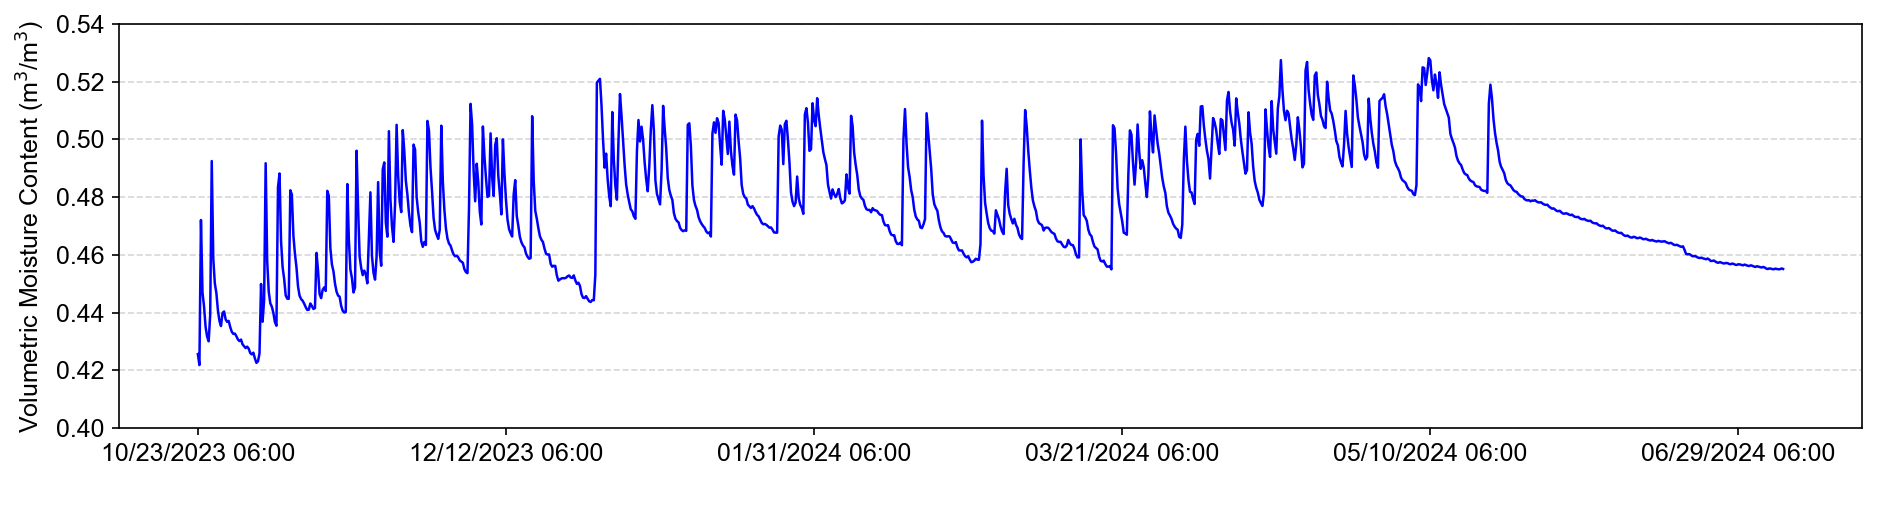

In [12]:
fig, ax=plt.subplots(figsize=(15,3.5), dpi=150)
merged_mc_df[merged_mc_df['logger_id']=='95135592']['calibrated VMC'][640:].plot(lw=1.2,c = 'blue')
plt.ylim(0.40, 0.54)
plt.ylabel('Volumetric Moisture Content (m$^3$/m$^3$)', fontsize=12)
plt.xlabel(' ', fontsize=12)
plt.xticks(fontsize=12);
plt.yticks(fontsize=12);
plt.grid(axis='y', linestyle='--', alpha=0.5)

### Export the data to csv

In [13]:
#export data since sensor was installed in the field (i.e where the VMC values are not zero)
field_data=merged_mc_df[merged_mc_df['calibrated VMC']>0]

# #export the data to csv
out_dir = r"W:\VUB\TMS network\data\UNESCO_IHP__WINS\processed"
field_data.to_csv(os.path.join(out_dir, 'unesco_ihp_wins_microclimate_data_.csv'))